In [39]:
import pandas as pd
import datetime
import numpy as np

from sklearn.base import TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [40]:
crimes = pd.read_csv('clean_crime.csv')

In [41]:
crimes['month'] = crimes['month'].astype(str)
crimes['time_of_day'] = crimes['time_of_day'].astype(str)
crimes['precinct'] = crimes['precinct'].astype(str)
crimes['city_housing'] = crimes['city_housing'].astype(str)



In [42]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

crimes = DataFrameImputer().fit_transform(crimes)

In [43]:
X = crimes[['month', 'time_of_day', 'precinct', 'crime_completed', 'borough_name', 'premises',
                  'jurisdiction_code', 'latitude', 'longitude', 'victim_age_group', 'victim_race', 'victim_sex',
                  'suspect_age_group', 'suspect_race', 'suspect_sex', 'city_housing']]

In [44]:
categorical_feature_mask = X.dtypes==object
numerical_features_mask = X.dtypes!=object
categorical_cols = X.columns[categorical_feature_mask].tolist()
numerical_cols = X.columns[numerical_features_mask].tolist()
X_cat = X[categorical_cols]
X_cat = pd.get_dummies(X_cat)
X = X_cat.join(X[numerical_cols])

In [45]:
X = pd.get_dummies(X)
y = crimes['offense_level']

In [46]:
y.value_counts()

MISDEMEANOR    26399
FELONY         15635
VIOLATION       7966
Name: offense_level, dtype: int64

In [47]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=426, stratify=y, test_size=.2)

In [49]:
bag = BaggingClassifier(n_estimators=100, n_jobs=-1)
bag.fit(X_train,y_train)
bag_pred = bag.predict(X_test)

In [50]:
print(metrics.confusion_matrix(y_test, bag_pred))
print(metrics.classification_report(y_test, bag_pred))

[[1155 1791  181]
 [ 949 3943  388]
 [ 222  952  419]]
              precision    recall  f1-score   support

      FELONY       0.50      0.37      0.42      3127
 MISDEMEANOR       0.59      0.75      0.66      5280
   VIOLATION       0.42      0.26      0.32      1593

    accuracy                           0.55     10000
   macro avg       0.50      0.46      0.47     10000
weighted avg       0.53      0.55      0.53     10000



In [51]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=3)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [52]:
print(metrics.confusion_matrix(y_test, rf_pred))
print(metrics.classification_report(y_test, rf_pred))

[[  87 3040    0]
 [  31 5249    0]
 [   3 1590    0]]


C:\Users\bentlia0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      FELONY       0.72      0.03      0.05      3127
 MISDEMEANOR       0.53      0.99      0.69      5280
   VIOLATION       0.00      0.00      0.00      1593

    accuracy                           0.53     10000
   macro avg       0.42      0.34      0.25     10000
weighted avg       0.51      0.53      0.38     10000



C:\Users\bentlia0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bentlia0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


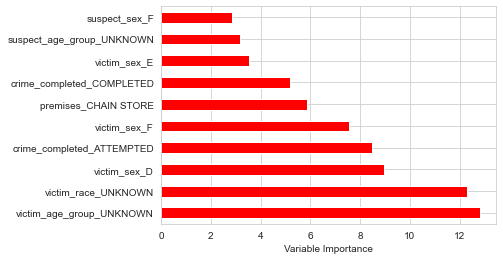

In [53]:
Importance = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X_train.columns)
Importance = Importance.iloc[rf.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=True)
Importance.sort_values('Importance', axis=0, ascending=False).head(10).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [54]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=.1)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

In [55]:
print(metrics.confusion_matrix(y_test, gb_pred))
print(metrics.classification_report(y_test, gb_pred))

[[ 432 2599   96]
 [ 239 4846  195]
 [  58 1254  281]]
              precision    recall  f1-score   support

      FELONY       0.59      0.14      0.22      3127
 MISDEMEANOR       0.56      0.92      0.69      5280
   VIOLATION       0.49      0.18      0.26      1593

    accuracy                           0.56     10000
   macro avg       0.55      0.41      0.39     10000
weighted avg       0.56      0.56      0.48     10000



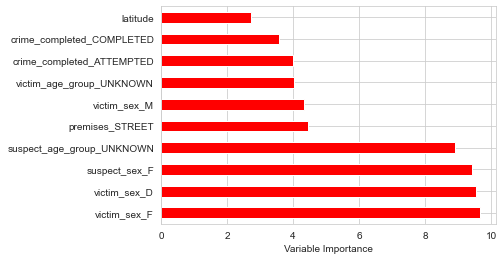

In [56]:
Importance = pd.DataFrame({'Importance':gb.feature_importances_*100}, index=X_train.columns)
Importance = Importance.iloc[gb.feature_importances_ > 0,:]
Importance = Importance.sort_values('Importance', axis=0, ascending=True)
Importance.sort_values('Importance', axis=0, ascending=False).head(10).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None